In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
data_dir = r'C:\Users\Habeeb\Downloads\Finale\dataset'

# ImageDataGenerator for preprocessing with additional augmentations
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% of the data for validation
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2
)

# Training data generator
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,
    class_mode='binary',
    subset='training',  # Use this subset for training
    shuffle=True
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use this subset for validation
)

Found 1325 images belonging to 2 classes.
Found 331 images belonging to 2 classes.


In [3]:
# Load the VGG16 model without the top fully connected layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features from training and validation images
def extract_features(generator, model):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * generator.batch_size >= generator.samples:
            break
    return np.concatenate(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_generator, vgg16_base)
validation_features, validation_labels = extract_features(validation_generator, vgg16_base)

# Flatten the features to fit KNN input
train_features = train_features.reshape(train_features.shape[0], -1)
validation_features = validation_features.reshape(validation_features.shape[0], -1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 

In [4]:
# Standardize the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
validation_features = scaler.transform(validation_features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=500)  # Adjust the number of components based on your dataset
train_features = pca.fit_transform(train_features)
validation_features = pca.transform(validation_features)

# Use SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
train_features_resampled, train_labels_resampled = smote.fit_resample(train_features, train_labels)


In [5]:
# Train the KNN model with resampled data
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_model = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
knn_model.fit(train_features_resampled, train_labels_resampled)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [6]:
# Evaluate the model on the validation set
val_predictions = knn_model.predict(validation_features)

# Generate classification report and confusion matrix
print(classification_report(validation_labels, val_predictions, target_names=train_generator.class_indices.keys()))
conf_matrix = confusion_matrix(validation_labels, val_predictions)
print(conf_matrix)

              precision    recall  f1-score   support

non-trachoma       0.63      0.22      0.32       203
    positive       0.39      0.80      0.52       128

    accuracy                           0.44       331
   macro avg       0.51      0.51      0.42       331
weighted avg       0.54      0.44      0.40       331

[[ 44 159]
 [ 26 102]]


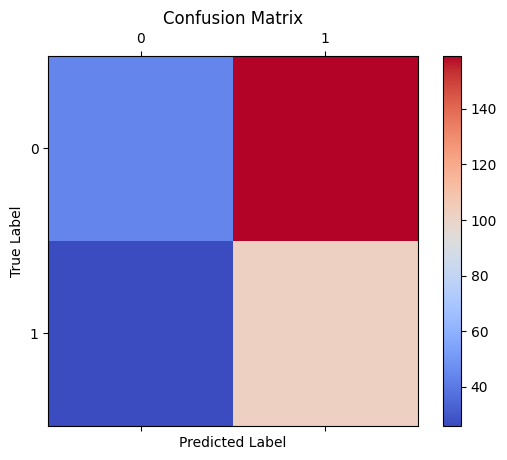

In [7]:
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap='coolwarm')
fig.colorbar(cax)
ax.set_title('Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# Save the figure
fig.savefig('confusion_matrix.png')

# Display the plot
plt.show()